In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [9]:
df = pd.read_csv('../data/data.csv', encoding='latin1')
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"]).dt.normalize()
print(df.shape)
df.head(3)

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom


In [3]:
# INGENIERIA DE VARIABLES
df = df[(df["Quantity"] != 0) & (df['CustomerID'].notnull())].copy()

df['quantity_buy'] = np.where(df['Quantity'] > 0, df['Quantity'], 0)
df['quantity_return'] = np.where(df['Quantity'] < 0, -df['Quantity'],0)

features = df.groupby('CustomerID').agg(
            total_compras=('InvoiceNo', 'nunique'),
            total_productos_comprados=('quantity_buy', 'sum'),
            total_productos_devoluciones=('quantity_return', 'sum'),
            total_gasto_comprado=('UnitPrice', lambda x: (df.loc[x.index, 'quantity_buy'] * x).sum()),
            total_gasto_devoluciones=('UnitPrice', lambda x: (df.loc[x.index, 'quantity_return'] * x).sum()),
            ).reset_index()

df['unique_buy'] = np.where(df['Quantity'] > 0, True, False)
df['unique_return'] = np.where(df['Quantity'] < 0, True, False)

buys = df[df['unique_buy']].groupby('CustomerID')['StockCode'].nunique().reset_index(name='products_unique_buys')
returns = df[df['unique_return']].groupby('CustomerID')['StockCode'].nunique().reset_index(name='products_unique_return')

features = features.merge(buys, on='CustomerID', how='left')
features = features.merge(returns, on='CustomerID', how='left')

features[['products_unique_buys', 'products_unique_return']] = features[
    ['products_unique_buys', 'products_unique_return']
].fillna(0).astype(int)

features

,CustomerID,total_compras,total_productos_comprados,total_productos_devoluciones,total_gasto_comprado,total_gasto_devoluciones,products_unique_buys,products_unique_return
0,12346.0,2,74215,74215,77183.60,77183.60,1,1
1,12347.0,7,2458,0,4310.00,0.00,103,0
2,12348.0,4,2341,0,1797.24,0.00,22,0
3,12349.0,1,631,0,1757.55,0.00,73,0
4,12350.0,1,197,0,334.40,0.00,17,0
...,...,...,...,...,...,...,...,...
4367,18280.0,1,45,0,180.60,0.00,10,0
4368,18281.0,1,54,0,80.82,0.00,7,0
4369,18282.0,3,103,5,178.05,1.45,12,1
4370,18283.0,16,1397,0,2094.88,0.00,263,0


In [16]:
# Ventasas churn
meses_obs = 3
meses_churn = 3
obs_ini = df['InvoiceDate'].min()

ventanas = []
ventana_id = 1

while True:
    obs_end = obs_ini + pd.DateOffset(months=meses_obs) - pd.DateOffset(days=1)
    churn_ini = obs_end + pd.DateOffset(days=1)
    churn_end = churn_ini + pd.DateOffset(months=meses_churn) - pd.DateOffset(days=1)

    if churn_end > df['InvoiceDate'].max():
        break

    df_obs = df[(df['InvoiceDate'] >= obs_ini) & (df['InvoiceDate'] <= obs_end)]
    df_churn = df[(df['InvoiceDate'] >= churn_ini) & (df['InvoiceDate'] <= churn_end)]

    customers_obs = df_obs['CustomerID'].dropna().unique()
    customer_churn = df_churn['CustomerID'].dropna().unique()

    for customer in customers_obs:

        df_cliente = df_obs[df_obs['CustomerID'] == customer].copy()
        df_cliente['quantity_buy'] = np.where(df_cliente['Quantity'] > 0, df_cliente['Quantity'], 0)
        df_cliente['quantity_return'] = np.where(df_cliente['Quantity'] < 0, -df_cliente['Quantity'],0)

        # Compras
        total_compras = df_cliente['quantity_buy'].nunique()
        total_productos_comprados = df_cliente['quantity_buy'].sum()
        total_gasto = (df_cliente['UnitPrice'] * df_cliente['quantity_buy']).sum()
        productos_unicos_comprados = df_cliente['StockCode'].nunique()

        # Devoluciones
        total_devoluciones = df_cliente['quantity_return'].nunique()
        total_productos_devoluciones = df_cliente['quantity_return'].sum()
        total_gasto_devoluciones = (df_cliente['UnitPrice'] * df_cliente['quantity_return']).sum()
        productos_unicos_devoluciones = df_cliente['StockCode'].nunique()

        # Promedio dias entre compras
        fechas = df_cliente['InvoiceDate'].drop_duplicates().sort_values()
        if len(fechas) > 1:
            diffs = fechas.diff().dropna()
            promedio_dias_entre_compras = diffs.mean().days
        else:
            promedio_dias_entre_compras = np.nan

        # Churn
        churn = 0 if customer in customer_churn else 1

        ventanas.append({
            'CustomerID': customer,
            'ventana_id': ventana_id,
            'total_compras': total_compras,
            'total_productos_comprados': total_productos_comprados,
            'total_gasto': total_gasto,
            'productos_unicos_comprados': productos_unicos_comprados,
            'total_devoluciones': total_devoluciones,
            'total_productos_devoluciones': total_productos_devoluciones,
            'total_gasto_devoluciones': total_gasto_devoluciones,
            'productos_unicos_devoluciones': productos_unicos_devoluciones,
            'promedio_dias_entre_compras': promedio_dias_entre_compras,
            'churn': churn
        })

    obs_ini = obs_ini + pd.DateOffset(months=meses_obs)
    ventana_id += 1

df_ventanas = pd.DataFrame(ventanas)
# df_ventanas['ventana_id'].value_counts()
df_ventanas


,CustomerID,ventana_id,total_compras,total_productos_comprados,total_gasto,productos_unicos_comprados,total_devoluciones,total_productos_devoluciones,total_gasto_devoluciones,productos_unicos_devoluciones,promedio_dias_entre_compras,churn
0,17850.0,1,7,1733,5391.21,24,5,40,102.58,24,35.0,1
1,13047.0,1,9,312,825.53,35,2,1,2.95,35,32.0,0
2,12583.0,1,18,1394,1907.58,42,2,1,18.00,42,25.0,0
3,13748.0,1,1,80,204.00,1,1,0,0.00,1,NaN,0
4,15100.0,1,3,80,876.00,1,4,22,240.90,1,8.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5764,17320.0,3,7,168,290.52,25,1,0,0.00,25,NaN,1
5765,17777.0,3,8,163,194.70,63,1,0,0.00,63,NaN,0
5766,15582.0,3,4,152,237.90,14,1,0,0.00,14,NaN,0
5767,16780.0,3,9,172,263.30,40,1,0,0.00,40,NaN,1


In [ ]:


# Si estás usando tu DataFrame final con todas las features + churn
# Filtramos solo las columnas numéricas
df_corr = df_ventanas.select_dtypes(include='number')

# Calculamos la matriz de correlación
corr_matrix = df_corr.corr()

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True, linewidths=0.5)

plt.title("Matriz de correlación entre variables", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
# Data set final

df_final = features.merge(df_ventanas[['CustomerID','etiqueta']], on='CustomerID', how='left')
df_final

,CustomerID,total_compras,total_productos_comprados,total_productos_devoluciones,total_gasto_comprado,total_gasto_devoluciones,products_unique_buys,products_unique_return,etiqueta
0,12346.0,2,74215,74215,77183.60,77183.60,1,1,1.0
1,12347.0,7,2458,0,4310.00,0.00,103,0,0.0
2,12347.0,7,2458,0,4310.00,0.00,103,0,0.0
3,12347.0,7,2458,0,4310.00,0.00,103,0,0.0
4,12348.0,4,2341,0,1797.24,0.00,22,0,0.0
...,...,...,...,...,...,...,...,...,...
6776,18282.0,3,103,5,178.05,1.45,12,1,1.0
6777,18283.0,16,1397,0,2094.88,0.00,263,0,0.0
6778,18283.0,16,1397,0,2094.88,0.00,263,0,0.0
6779,18283.0,16,1397,0,2094.88,0.00,263,0,0.0


In [6]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6781 entries, 0 to 6780
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CustomerID                    6781 non-null   float64
 1   total_compras                 6781 non-null   int64  
 2   total_productos_comprados     6781 non-null   int64  
 3   total_productos_devoluciones  6781 non-null   int64  
 4   total_gasto_comprado          6781 non-null   float64
 5   total_gasto_devoluciones      6781 non-null   float64
 6   products_unique_buys          6781 non-null   int64  
 7   products_unique_return        6781 non-null   int64  
 8   etiqueta                      5769 non-null   float64
dtypes: float64(4), int64(5)
memory usage: 476.9 KB


In [33]:
data_max = df['InvoiceDate'].max()
churn_data_ini = data_max - pd.DateOffset(months=6)

compras_churn_window = df[
    (df['InvoiceDate'] >= churn_data_ini) &
    (df['InvoiceDate'] <= data_max)
].copy()

churn_data_ini
compras_churn_window


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
219974,556109,22427,ENAMEL FLOWER JUG CREAM,3,2011-06-09,5.95,13741.0,United Kingdom
219975,556109,22424,ENAMEL BREAD BIN CREAM,2,2011-06-09,12.75,13741.0,United Kingdom
219976,556109,22364,GLASS JAR DIGESTIVE BISCUITS,6,2011-06-09,2.95,13741.0,United Kingdom
219977,556109,22360,GLASS JAR ENGLISH CONFECTIONERY,6,2011-06-09,2.95,13741.0,United Kingdom
219978,556109,21534,DAIRY MAID LARGE MILK JUG,3,2011-06-09,4.95,13741.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France


In [ ]:
df = df[(df["Quantity"] != 0) & (df['CustomerID'].notnull())].copy()

df['quantity_buy'] = np.where(df['Quantity'] > 0, df['Quantity'], 0)
df['quantity_return'] = np.where(df['Quantity'] < 0, -df['Quantity'],0)

In [14]:
features = df.groupby('CustomerID').agg(
            total_compras=('InvoiceNo', 'nunique'),
            total_items=('quantity_buy', 'sum'),
            total_devoluciones=('quantity_return', 'sum'),
            total_gasto=('UnitPrice', lambda x: (df.loc[x.index, 'quantity_buy'] * x).sum()),
            total_gasto_devoluciones=('UnitPrice', lambda x: (df.loc[x.index, 'quantity_return'] * x).sum()),
            primera_compra=('InvoiceDate', 'min'),
            ultima_compra=('InvoiceDate', 'max'),
            ).reset_index()

In [16]:
features

,CustomerID,total_compras,total_items,total_devoluciones,total_gasto,total_gasto_devoluciones,primera_compra,ultima_compra
0,12346.0,2,74215,74215,77183.60,77183.60,2011-01-18,2011-01-18
1,12347.0,7,2458,0,4310.00,0.00,2010-12-07,2011-12-07
2,12348.0,4,2341,0,1797.24,0.00,2010-12-16,2011-09-25
3,12349.0,1,631,0,1757.55,0.00,2011-11-21,2011-11-21
4,12350.0,1,197,0,334.40,0.00,2011-02-02,2011-02-02
...,...,...,...,...,...,...,...,...
4367,18280.0,1,45,0,180.60,0.00,2011-03-07,2011-03-07
4368,18281.0,1,54,0,80.82,0.00,2011-06-12,2011-06-12
4369,18282.0,3,103,5,178.05,1.45,2011-08-05,2011-12-02
4370,18283.0,16,1397,0,2094.88,0.00,2011-01-06,2011-12-06


In [17]:
features['total_compras'].value_counts().sort_index()

total_compras
1      1313
2       817
3       490
4       377
5       288
       ... 
118       2
128       1
169       1
224       1
248       1
Name: count, Length: 65, dtype: int64

In [108]:
df.loc[(df['CustomerID'] == 12346) 
    #    & (df['StockCode'] == '82483')
       ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,quantity_buy,quantity_return
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,12346.0,United Kingdom,74215,0
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18,1.04,12346.0,United Kingdom,0,74215


In [109]:
_1 = df[df['Quantity'] > 0].groupby('CustomerID')['StockCode'].nunique().reset_index(name='products_unique_buys')
_2 = df[df['Quantity'] < 0].groupby('CustomerID')['StockCode'].nunique().reset_index(name='products_unique_return')
features_ = features.merge(_1, on='CustomerID', how='left')
features_ = features_.merge(_2, on='CustomerID', how='left')
features_

,CustomerID,total_compras,total_items,total_devoluciones,total_gasto,total_gasto_devoluciones,primera_compra,ultima_compra,products_unique_buys,products_unique_return
0,12346.0,2,74215,74215,77183.60,77183.60,2011-01-18,2011-01-18,1.0,1.0
1,12347.0,7,2458,0,4310.00,0.00,2010-12-07,2011-12-07,103.0,NaN
2,12348.0,4,2341,0,1797.24,0.00,2010-12-16,2011-09-25,22.0,NaN
3,12349.0,1,631,0,1757.55,0.00,2011-11-21,2011-11-21,73.0,NaN
4,12350.0,1,197,0,334.40,0.00,2011-02-02,2011-02-02,17.0,NaN
...,...,...,...,...,...,...,...,...,...,...
4367,18280.0,1,45,0,180.60,0.00,2011-03-07,2011-03-07,10.0,NaN
4368,18281.0,1,54,0,80.82,0.00,2011-06-12,2011-06-12,7.0,NaN
4369,18282.0,3,103,5,178.05,1.45,2011-08-05,2011-12-02,12.0,1.0
4370,18283.0,16,1397,0,2094.88,0.00,2011-01-06,2011-12-06,263.0,NaN


In [18]:
df['unique_buy'] = np.where(df['Quantity'] > 0, True, False)
df['unique_return'] = np.where(df['Quantity'] < 0, True, False)


buys = df[df['unique_buy']].groupby('CustomerID')['StockCode'].nunique().reset_index(name='products_unique_buys')
returns = df[df['unique_return']].groupby('CustomerID')['StockCode'].nunique().reset_index(name='products_unique_return')

features_ = features.merge(buys, on='CustomerID', how='left')
features_ = features_.merge(returns, on='CustomerID', how='left')

features_[['products_unique_buys', 'products_unique_return']] = features_[
    ['products_unique_buys', 'products_unique_return']
].fillna(0).astype(int)

features_

,CustomerID,total_compras,total_items,total_devoluciones,total_gasto,total_gasto_devoluciones,primera_compra,ultima_compra,products_unique_buys,products_unique_return
0,12346.0,2,74215,74215,77183.60,77183.60,2011-01-18,2011-01-18,1,1
1,12347.0,7,2458,0,4310.00,0.00,2010-12-07,2011-12-07,103,0
2,12348.0,4,2341,0,1797.24,0.00,2010-12-16,2011-09-25,22,0
3,12349.0,1,631,0,1757.55,0.00,2011-11-21,2011-11-21,73,0
4,12350.0,1,197,0,334.40,0.00,2011-02-02,2011-02-02,17,0
...,...,...,...,...,...,...,...,...,...,...
4367,18280.0,1,45,0,180.60,0.00,2011-03-07,2011-03-07,10,0
4368,18281.0,1,54,0,80.82,0.00,2011-06-12,2011-06-12,7,0
4369,18282.0,3,103,5,178.05,1.45,2011-08-05,2011-12-02,12,1
4370,18283.0,16,1397,0,2094.88,0.00,2011-01-06,2011-12-06,263,0


In [19]:
features_['dias_entre_compra'] = (features_['ultima_compra'] - features_['primera_compra']).dt.days
features_['dias_entre_compra'].fillna(0)
features_

,CustomerID,total_compras,total_items,total_devoluciones,total_gasto,total_gasto_devoluciones,primera_compra,ultima_compra,products_unique_buys,products_unique_return,dias_entre_compra
0,12346.0,2,74215,74215,77183.60,77183.60,2011-01-18,2011-01-18,1,1,0
1,12347.0,7,2458,0,4310.00,0.00,2010-12-07,2011-12-07,103,0,365
2,12348.0,4,2341,0,1797.24,0.00,2010-12-16,2011-09-25,22,0,283
3,12349.0,1,631,0,1757.55,0.00,2011-11-21,2011-11-21,73,0,0
4,12350.0,1,197,0,334.40,0.00,2011-02-02,2011-02-02,17,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4367,18280.0,1,45,0,180.60,0.00,2011-03-07,2011-03-07,10,0,0
4368,18281.0,1,54,0,80.82,0.00,2011-06-12,2011-06-12,7,0,0
4369,18282.0,3,103,5,178.05,1.45,2011-08-05,2011-12-02,12,1,119
4370,18283.0,16,1397,0,2094.88,0.00,2011-01-06,2011-12-06,263,0,334


In [20]:
features_['churn'] = [ 1 if x > 180 else 0 for x in features_['dias_entre_compra'] ]
features_

,CustomerID,total_compras,total_items,total_devoluciones,total_gasto,total_gasto_devoluciones,primera_compra,ultima_compra,products_unique_buys,products_unique_return,dias_entre_compra,churn
0,12346.0,2,74215,74215,77183.60,77183.60,2011-01-18,2011-01-18,1,1,0,0
1,12347.0,7,2458,0,4310.00,0.00,2010-12-07,2011-12-07,103,0,365,1
2,12348.0,4,2341,0,1797.24,0.00,2010-12-16,2011-09-25,22,0,283,1
3,12349.0,1,631,0,1757.55,0.00,2011-11-21,2011-11-21,73,0,0,0
4,12350.0,1,197,0,334.40,0.00,2011-02-02,2011-02-02,17,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4367,18280.0,1,45,0,180.60,0.00,2011-03-07,2011-03-07,10,0,0,0
4368,18281.0,1,54,0,80.82,0.00,2011-06-12,2011-06-12,7,0,0,0
4369,18282.0,3,103,5,178.05,1.45,2011-08-05,2011-12-02,12,1,119,0
4370,18283.0,16,1397,0,2094.88,0.00,2011-01-06,2011-12-06,263,0,334,1


In [119]:
df[df['CustomerID'] == 12348]\
    ['InvoiceDate'].value_counts().sort_index()

InvoiceDate
2010-12-16    17
2011-01-25     6
2011-04-05     5
2011-09-25     3
Name: count, dtype: int64

In [132]:
df[df['CustomerID'] == 12348].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,quantity_buy,quantity_return,unique_buy,unique_return
34083,539318,84992,72 SWEETHEART FAIRY CAKE CASES,72,2010-12-16,0.55,12348.0,Finland,72,0,True,False
34084,539318,22951,60 CAKE CASES DOLLY GIRL DESIGN,72,2010-12-16,0.55,12348.0,Finland,72,0,True,False
34085,539318,84991,60 TEATIME FAIRY CAKE CASES,24,2010-12-16,0.55,12348.0,Finland,24,0,True,False
34086,539318,84991,60 TEATIME FAIRY CAKE CASES,120,2010-12-16,0.42,12348.0,Finland,120,0,True,False
34087,539318,21213,PACK OF 72 SKULL CAKE CASES,24,2010-12-16,0.55,12348.0,Finland,24,0,True,False


In [130]:
compras = df[df['Quantity'] > 0][['CustomerID', 'InvoiceDate']].drop_duplicates()
compras['dias_diff'] = compras.groupby('CustomerID')['InvoiceDate'].diff().dt.days
# compras[compras['CustomerID'] == 12348]
promedio_dias = compras.groupby('CustomerID')['dias_diff'].mean().reset_index(name='promedio_dias_entre_compras').fillna(0).round(2)
promedio_dias

,CustomerID,promedio_dias_entre_compras
0,12346.0,0.00
1,12347.0,60.83
2,12348.0,94.33
3,12349.0,0.00
4,12350.0,0.00
...,...,...
4334,18280.0,0.00
4335,18281.0,0.00
4336,18282.0,119.00
4337,18283.0,25.69


In [133]:
features_ = features_.merge(promedio_dias, on='CustomerID', how='left')
features_

,CustomerID,total_compras,total_items,total_devoluciones,total_gasto,total_gasto_devoluciones,primera_compra,ultima_compra,products_unique_buys,products_unique_return,dias_entre_compra,churn,promedio_dias_entre_compras
0,12346.0,2,74215,74215,77183.60,77183.60,2011-01-18,2011-01-18,1,1,0,0,0.00
1,12347.0,7,2458,0,4310.00,0.00,2010-12-07,2011-12-07,103,0,365,1,60.83
2,12348.0,4,2341,0,1797.24,0.00,2010-12-16,2011-09-25,22,0,283,1,94.33
3,12349.0,1,631,0,1757.55,0.00,2011-11-21,2011-11-21,73,0,0,0,0.00
4,12350.0,1,197,0,334.40,0.00,2011-02-02,2011-02-02,17,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367,18280.0,1,45,0,180.60,0.00,2011-03-07,2011-03-07,10,0,0,0,0.00
4368,18281.0,1,54,0,80.82,0.00,2011-06-12,2011-06-12,7,0,0,0,0.00
4369,18282.0,3,103,5,178.05,1.45,2011-08-05,2011-12-02,12,1,119,0,119.00
4370,18283.0,16,1397,0,2094.88,0.00,2011-01-06,2011-12-06,263,0,334,1,25.69


In [134]:
features_.head()

,CustomerID,total_compras,total_items,total_devoluciones,total_gasto,total_gasto_devoluciones,primera_compra,ultima_compra,products_unique_buys,products_unique_return,dias_entre_compra,churn,promedio_dias_entre_compras
0,12346.0,2,74215,74215,77183.60,77183.6,2011-01-18,2011-01-18,1,1,0,0,0.00
1,12347.0,7,2458,0,4310.00,0.0,2010-12-07,2011-12-07,103,0,365,1,60.83
2,12348.0,4,2341,0,1797.24,0.0,2010-12-16,2011-09-25,22,0,283,1,94.33
3,12349.0,1,631,0,1757.55,0.0,2011-11-21,2011-11-21,73,0,0,0,0.00
4,12350.0,1,197,0,334.40,0.0,2011-02-02,2011-02-02,17,0,0,0,0.00


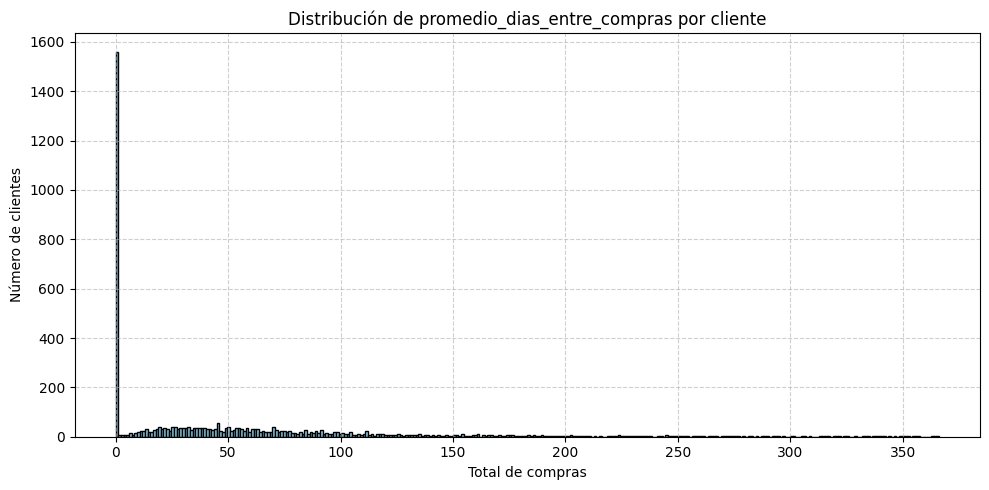

In [131]:
plt.figure(figsize=(10, 5))
plt.hist(promedio_dias['promedio_dias_entre_compras'], bins=310, color='skyblue', edgecolor='black')
plt.title('Distribución de promedio_dias_entre_compras por cliente')
plt.xlabel('Total de compras')
plt.ylabel('Número de clientes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

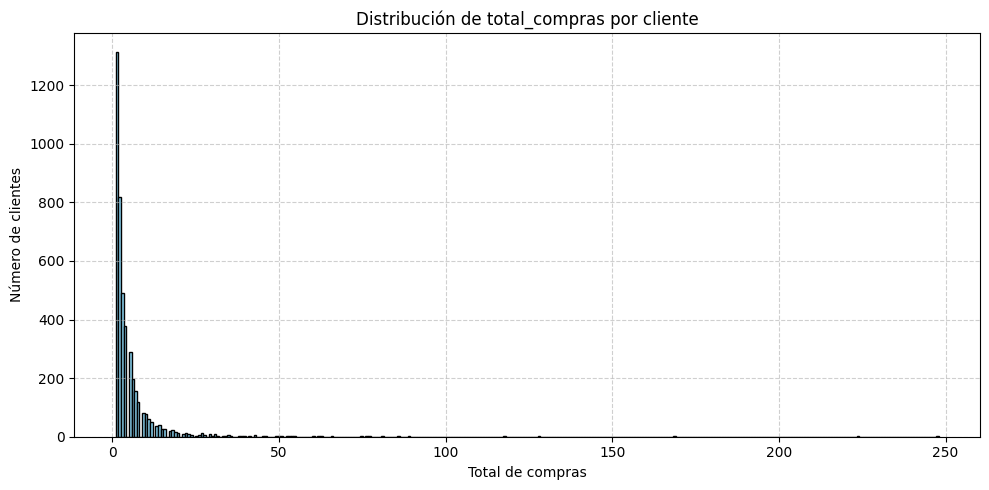

In [60]:
plt.figure(figsize=(10, 5))
plt.hist(features['total_compras'], bins=310, color='skyblue', edgecolor='black')
plt.title('Distribución de total_compras por cliente')
plt.xlabel('Total de compras')
plt.ylabel('Número de clientes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

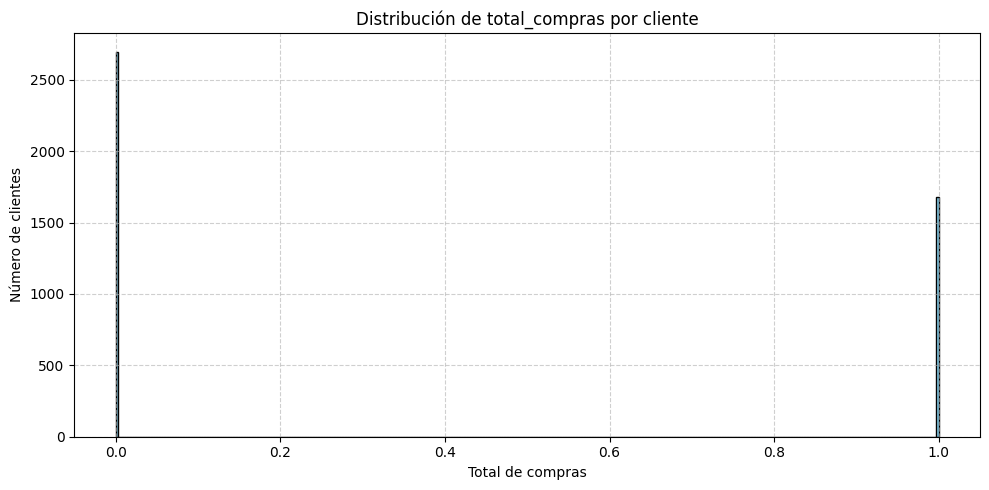

In [59]:
plt.figure(figsize=(10, 5))
plt.hist(features_['churn'], bins=310, color='skyblue', edgecolor='black')
plt.title('Distribución de total_compras por cliente')
plt.xlabel('Total de compras')
plt.ylabel('Número de clientes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

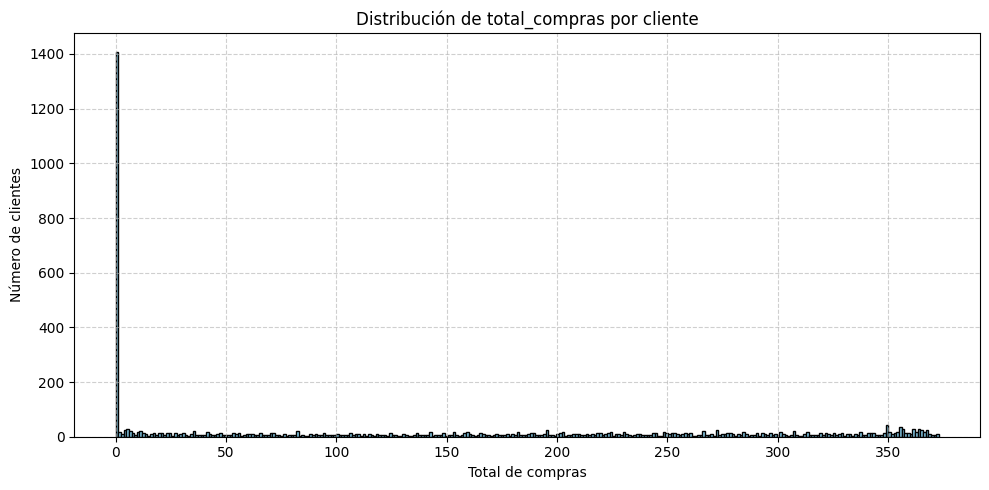

In [55]:
plt.figure(figsize=(10, 5))
plt.hist(features_['dias_entre_compra'], bins=310, color='skyblue', edgecolor='black')
plt.title('Distribución de total_compras por cliente')
plt.xlabel('Total de compras')
plt.ylabel('Número de clientes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

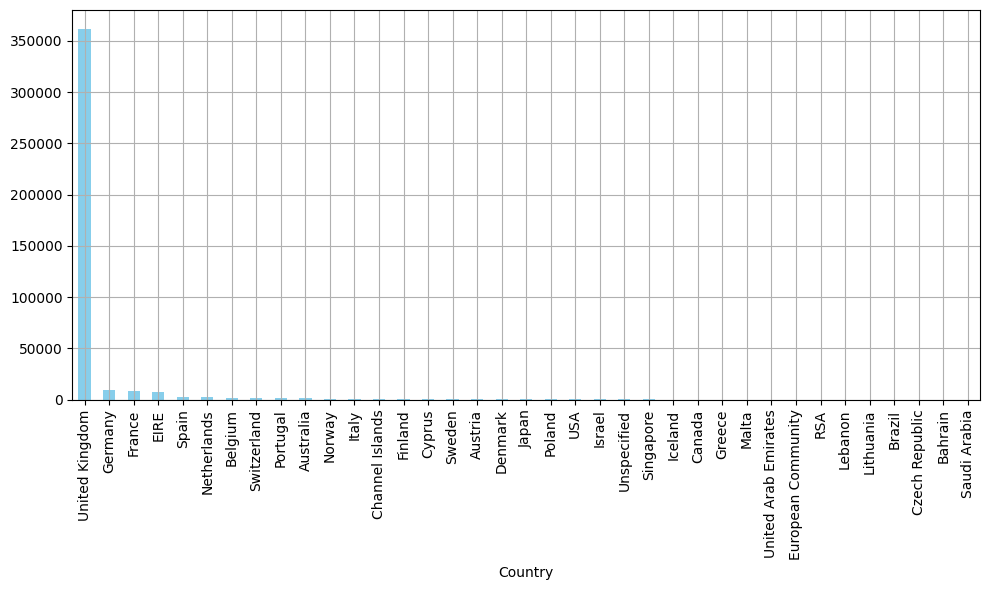

In [37]:
plt.figure(figsize=(10, 6))
df['Country'].value_counts().plot(kind='bar', color='skyblue')
plt.grid(True)
plt.tight_layout()
plt.show()

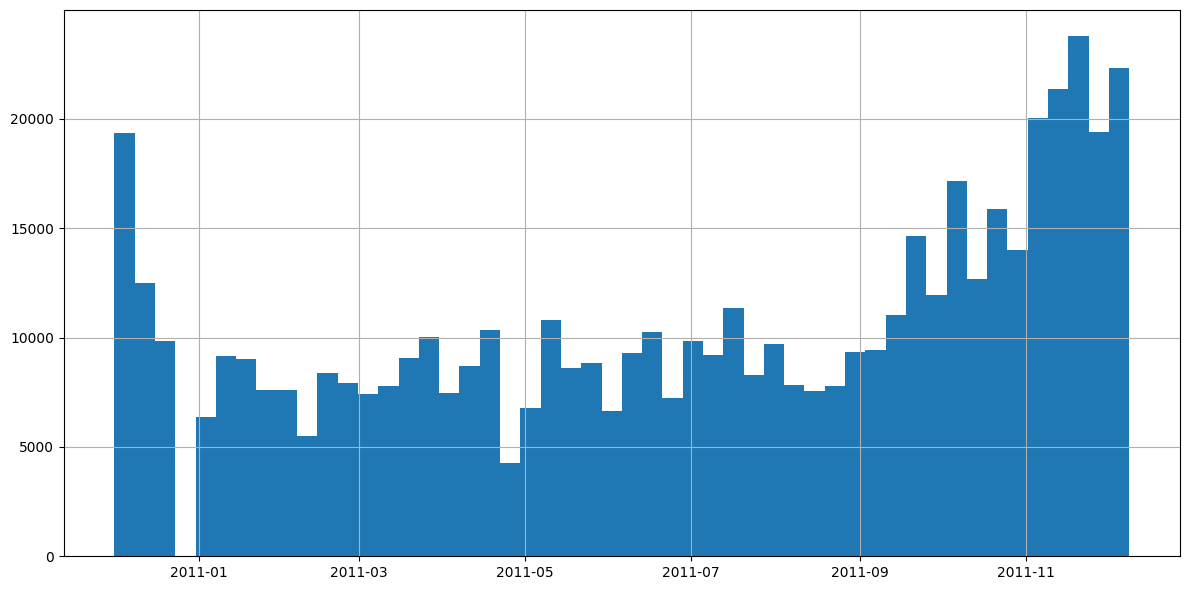

In [46]:
# SOLO COMPRAS SIN DEVOLUCIONES
df_compras = df[df['Quantity'] > 0].copy()
plt.figure(figsize=(12, 6))
plt.hist(df_compras['InvoiceDate'], bins=50)
plt.grid(True)
plt.tight_layout()
plt.show()

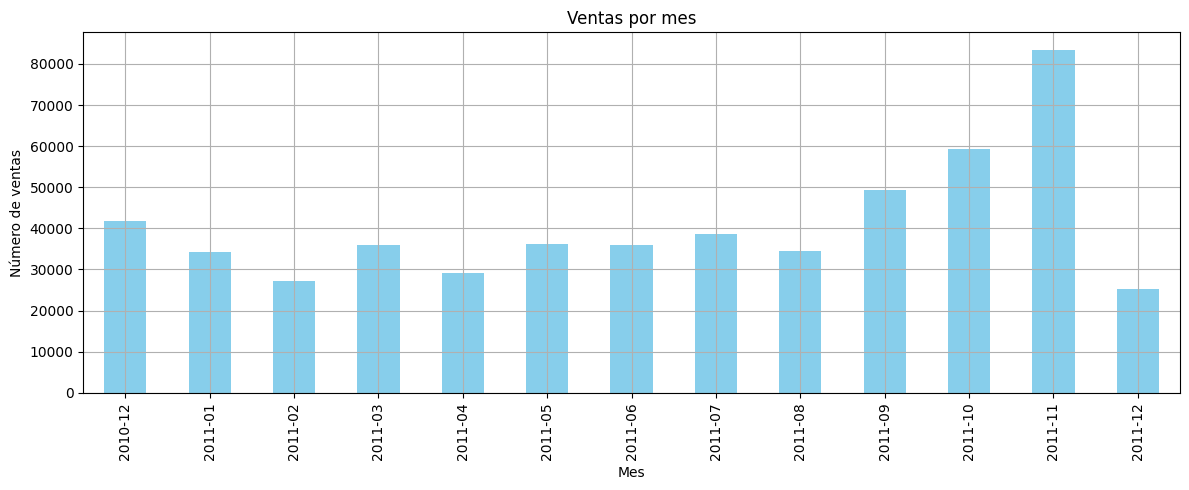

In [49]:
df_compras['month'] = df_compras['InvoiceDate'].dt.to_period('M')  # Agrupar por mes
ventas_por_mes = df_compras.groupby('month').size()

plt.figure(figsize=(12, 5))
ventas_por_mes.plot(kind='bar', color='skyblue')
plt.title('Ventas por mes')
plt.ylabel('Número de ventas')
plt.xlabel('Mes')
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
df_compras

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,2010-12
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680.0,France,2011-12
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France,2011-12
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France,2011-12
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France,2011-12


In [57]:
facturas_unicas = df_compras[['InvoiceNo', 'month']].drop_duplicates()
ventas_por_mes = facturas_unicas.groupby('month').size()
ventas_por_mes

# plt.figure(figsize=(12, 5))
# ventas_por_mes.plot(kind='bar', color='skyblue')
# plt.title('Ventas (facturas únicas) por mes')
# plt.ylabel('Cantidad de facturas')
# plt.xlabel('Mes')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

month
2010-12    1629
2011-01    1120
2011-02    1126
2011-03    1531
2011-04    1318
2011-05    1731
2011-06    1576
2011-07    1540
2011-08    1409
2011-09    1896
2011-10    2129
2011-11    2884
2011-12     839
Freq: M, dtype: int64

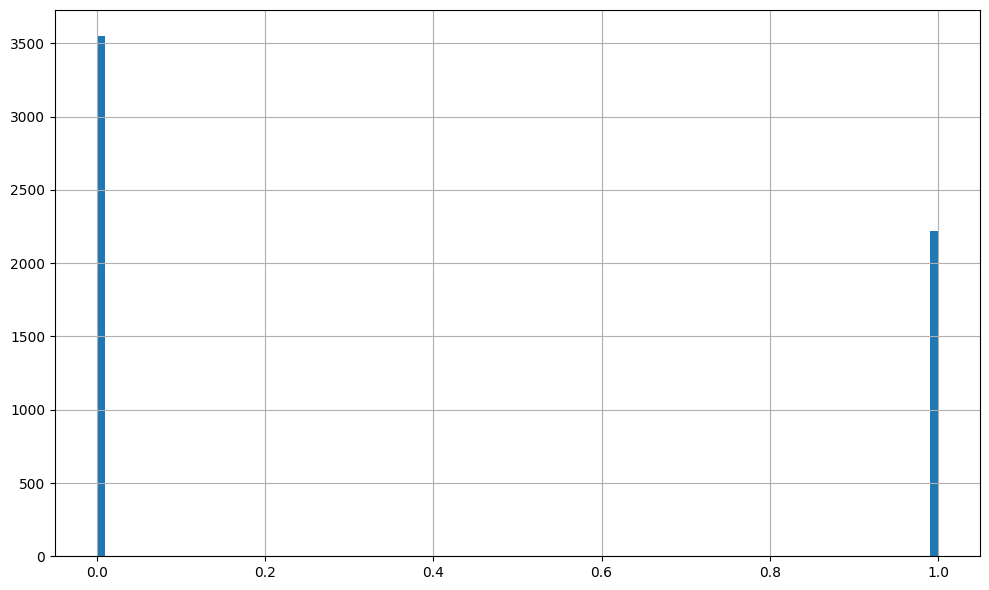

In [83]:
plt.figure(figsize=(10, 6))
plt.hist(df_final['etiqueta'], bins=100)
plt.grid(True)
plt.tight_layout()
plt.show()